In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.naive_bayes import GaussianNB


In [16]:
df_train = pd.read_csv('train.csv')

In [17]:
df_train = df_train.fillna({"Embarked": "S"})
#df_test = df_test.fillna({"Fare": 7.89580})
df_train['Age'] = df_train.groupby(['Sex', 'Pclass'])['Age'].apply(lambda x: x.fillna(x.median()))
df_train['AgeBand'] = pd.qcut(df_train['Age'], 10, labels = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
df_train['Sex'] = df_train['Sex'].map({"male": 0, "female": 1})
df_train['Ticket_Frequency'] = df_train.groupby('Ticket')['Ticket'].transform('count')
df_train['FareBand'] = pd.qcut(df_train['Fare'], 10, labels = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

df_train['Title'] = df_train['Name'].str.split(', ', expand=True)[1].str.split('.', expand=True)[0]
df_train['Is_Married'] = 0
df_train['Is_Married'].loc[df_train['Title'] == 'Mrs'] = 1
df_train['Title'] = df_train['Title'].replace(['Miss', 'Mrs','Ms', 'Mlle', 'Lady', 'Mme', 'the Countess', 'Dona'], 'Miss/Mrs/Ms')
df_train['Title'] = df_train['Title'].replace(['Dr', 'Col', 'Major', 'Jonkheer', 'Capt', 'Sir', 'Don', 'Rev'], 'Dr/Military/Noble/Clergy')
df_train['Title'] = df_train['Title'].map({"Mr": 0, "Miss/Mrs/Ms": 1, "Master": 2, "Dr/Military/Noble/Clergy": 3})
df_train['Title'].fillna(0, inplace=True)

df_train['FamilySize'] = df_train['SibSp'] + df_train['Parch'] + 1
df_train['IsAlone'] = 0
df_train.loc[df_train['FamilySize'] == 1, 'IsAlone'] = 1

df_train['Cabin'].fillna('U', inplace=True)
df_train['Cabin'] = df_train['Cabin'].apply(lambda x: x[0])
replacement = {
    'T': 0,
    'U': 1,
    'A': 2,
    'G': 3,
    'C': 4,
    'F': 5,
    'B': 6,
    'E': 7,
    'D': 8
}

df_train['Cabin'] = df_train['Cabin'].apply(lambda x: replacement.get(x))
df_train['Cabin'] = StandardScaler().fit_transform(df_train['Cabin'].values.reshape(-1, 1))

df_train['Embarked'] = df_train['Embarked'].map({"S": 0, "Q": 1, "C": 2})


D:\Anaconda\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [18]:
df_train['IsWomanOrBoy'] = ((df_train.Title == 'Master') | (df_train.Sex == 'female'))
df_train['LastName'] = df_train.Name.str.split(',').str[0]
family = df_train.groupby(df_train.LastName).Survived
df_train['WomanOrBoyCount'] = family.transform(lambda s: s[df_train.IsWomanOrBoy].fillna(0).count())
df_train['WomanOrBoyCount'] = df_train.mask(df_train.IsWomanOrBoy, df_train.WomanOrBoyCount - 1, axis=0)
df_train['FamilySurvivedCount'] = family.transform(lambda s: s[df_train.IsWomanOrBoy].fillna(0).sum())
df_train['FamilySurvivedCount'] = df_train.mask(df_train.IsWomanOrBoy, df_train.FamilySurvivedCount - df_train.Survived.fillna(0), axis=0)
df_train['WomanOrBoySurvived'] = df_train.FamilySurvivedCount / df_train.WomanOrBoyCount.replace(0, np.nan)
df_train['Alone'] = (df_train.WomanOrBoyCount == 0)




proper_test = pd.read_csv('TITANICTEST.csv')
proper_test['Cabin'].fillna('U', inplace=True)
proper_test['Cabin'] = proper_test['Cabin'].apply(lambda x: x[0])
proper_test = proper_test.fillna({"Fare": 7.89580})
proper_test['Age'] = proper_test.groupby(['Sex', 'Pclass'])['Age'].apply(lambda x: x.fillna(x.median()))
proper_test['AgeBand'] = pd.qcut(proper_test['Age'], 10, labels = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
proper_test['Sex'] = proper_test['Sex'].map({"male": 0, "female": 1})
proper_test['FareBand'] = pd.qcut(proper_test['Fare'], 4, labels = [1, 2, 3, 4])
proper_test['FamilySize'] = proper_test['SibSp'] + proper_test['Parch'] + 1
proper_test['Ticket_Frequency'] = proper_test.groupby('Ticket')['Ticket'].transform('count')
proper_test['IsAlone'] = 0
proper_test = proper_test.fillna({"Embarked": "S"})
proper_test['Cabin'] = proper_test['Cabin'].apply(lambda x: replacement.get(x))
proper_test['Cabin'] = StandardScaler().fit_transform(proper_test['Cabin'].values.reshape(-1, 1))
proper_test['Pclass'] = proper_test['Pclass']
proper_test.loc[proper_test['FamilySize'] == 1, 'IsAlone'] = 1
proper_test['Title'] = proper_test['Name'].str.split(', ', expand=True)[1].str.split('.', expand=True)[0]
proper_test['Is_Married'] = 0
proper_test['Is_Married'].loc[proper_test['Title'] == 'Mrs'] = 1
proper_test['Title'] = proper_test['Title'].replace(['Miss', 'Mrs','Ms', 'Mlle', 'Lady', 'Mme', 'the Countess', 'Dona'], 'Miss/Mrs/Ms')
proper_test['Title'] = proper_test['Title'].map({"Mr": 0, "Miss/Mrs/Ms": 1, "Master": 2, "Dr/Military/Noble/Clergy": 3})
proper_test['Title'].fillna(0, inplace=True)
proper_test['Embarked'] = proper_test['Embarked'].map({"S": 0, "Q": 1, "C": 2})

proper_test['IsWomanOrBoy'] = ((proper_test.Title == 'Master') | (proper_test.Sex == 'female'))
proper_test['LastName'] = proper_test.Name.str.split(',').str[0]
family = proper_test.groupby(proper_test.LastName).Survived
proper_test['WomanOrBoyCount'] = family.transform(lambda s: s[proper_test.IsWomanOrBoy].fillna(0).count())
proper_test['WomanOrBoyCount'] = proper_test.mask(proper_test.IsWomanOrBoy, proper_test.WomanOrBoyCount - 1, axis=0)
proper_test['FamilySurvivedCount'] = family.transform(lambda s: s[proper_test.IsWomanOrBoy].fillna(0).sum())
proper_test['FamilySurvivedCount'] = proper_test.mask(df_train.IsWomanOrBoy, proper_test.FamilySurvivedCount - df_train.Survived.fillna(0), axis=0)
proper_test['WomanOrBoySurvived'] = proper_test.FamilySurvivedCount / proper_test.WomanOrBoyCount.replace(0, np.nan)
proper_test['Alone'] = (proper_test.WomanOrBoyCount == 0)

import itertools



max_acc = 0
#features = ["Pclass", "Sex","Embarked","Ticket_Frequency","Age", "Fare", "FamilySize", "Title", "Is_Married","IsAlone", "Cabin"]


features = [ 'Pclass', 'Sex', 'Cabin', 'AgeBand',
       'Ticket_Frequency', 'FareBand', 'FamilySize',
       'IsAlone', 'IsWomanOrBoy',
       'FamilySurvivedCount', 'WomanOrBoySurvived', 'Alone']
#features = ["Pclass","AgeBand", "Sex","Ticket_Frequency", "FareBand", "FamilySize", "Title", "Is_Married","IsAlone", "Cabin"]
for L in range(3, len(features)+1):
    for subset in itertools.combinations(features, L):
        feat = list(subset)
        X = df_train[feat]
        y =  df_train.Survived
        X_test = proper_test[feat]
        model = RandomForestClassifier()
        #model = RandomForestClassifier(criterion='gini',n_estimators=1100,max_depth=5,min_samples_split=4,min_samples_leaf=5,max_features='auto',oob_score=True,random_state=42,n_jobs=-1,verbose=0)
        #model = GradientBoostingClassifier(n_estimators=100, max_depth=5, random_state=1)
        #model = XGBClassifier(n_estimators=100, max_depth=5, random_state=1, verbosity = 0)
        model.fit(X, y)
        X = proper_test[feat]
        pred = model.predict(X)

        y = proper_test.Survived
        if accuracy_score(y, pred) > max_acc:
            max_acc = accuracy_score(y, pred)
            print(feat,accuracy_score(y, pred))

In [21]:
features = ['Pclass', 'IsWomanOrBoy', 'WomanOrBoySurvived', 'Alone', 'AgeBand', 'Sex', 'FareBand', 'FamilySize', 'Is_Married']

X = df_train[features]
y =  df_train.Survived
x_train, x_val, y_train, y_val = train_test_split(X, y, test_size = 0.3, random_state = 0)


model = RandomForestClassifier()
model.fit(x_train, y_train)


pred = model.predict(x_val)
print(accuracy_score(y_val, pred))

0.8022388059701493


In [22]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, cross_validate

              precision    recall  f1-score   support

           0       0.82      0.87      0.85       168
           1       0.76      0.69      0.72       100

    accuracy                           0.80       268
   macro avg       0.79      0.78      0.78       268
weighted avg       0.80      0.80      0.80       268



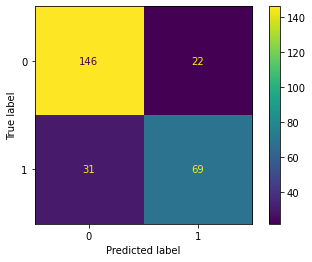

In [23]:
print(classification_report(y_val, pred))

cm = confusion_matrix(y_val, pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.show()

In [24]:
features = ['Pclass', 'IsWomanOrBoy', 'WomanOrBoySurvived', 'Alone', 'AgeBand', 'Sex', 'FareBand', 'FamilySize', 'Is_Married']
from sklearn.linear_model import LogisticRegression
X = df_train[features]
y =  df_train.Survived
x_train, x_val, y_train, y_val = train_test_split(X, y, test_size = 0.3, random_state = 0)


model = LogisticRegression()
model.fit(x_train, y_train)


pred = model.predict(x_val)
print(accuracy_score(y_val, pred))

0.8208955223880597


D:\Anaconda\lib\site-packages\sklearn\utils\validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)


              precision    recall  f1-score   support

           0       0.84      0.88      0.86       168
           1       0.78      0.73      0.75       100

    accuracy                           0.82       268
   macro avg       0.81      0.80      0.81       268
weighted avg       0.82      0.82      0.82       268



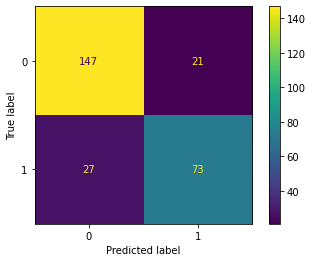

In [25]:
print(classification_report(y_val, pred))

cm = confusion_matrix(y_val, pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.show()